<h1 align="center">Scientific Programming in Python</h1>
<h2 align="center"> Topic 6: Python Profiling and Optimization </h2> 


_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - May 2017._

In [1]:
%matplotlib inline

import numpy as np
import numexpr as ne
import numba
import random
import matplotlib.pyplot as plt
import scipy as sp
import sys
from ipywidgets import interact, interactive, fixed

## Table of Contents
* [1.- About Optimization](#about)
* [2.- Time Profiling](#time)
* [3.- Memory Profiling](#memory)
* [4.- Application: K-means Clustering Algorithm](#application)

<div id='about' />
## 1.- About Optimization

_"The real problem is that programmers have spent far too much time worrying about efficiency in the wrong places and at the wrong times; premature optimization is the root of all evil (or at least most of it) in programming"._ __Donald Knuth__.

* Optimizing code prematurely is generally considered a bad practice.
* Code optimization should only be conducted when it's really needed.
* We should know exactly where we need to optimize your code.
* Typically the majority of the execution time comprises a relatively small part of the code.
* __Optimization should never be done without preliminary profiling__.

<div id='time' />
## 2.- Time Profiling

### 2.1- Time Benchmarking: `timeit`

The `%timeit` magic and the `%%timeit` cell magic allow you to quickly evaluate (__benchmark__) the time taken by one or several Python statements.

Some useful options: `%timeit?`

__Options__:

- __n__: Execute the given statement <N> times in a loop. If this value
is not given, a fitting value is chosen.

- __r__: Repeat the loop iteration <R> times and take the best result.
Default: 3

- __t__: Use time.time to measure the time, which is the default on Unix.
This function measures wall time.

- __c__: Use time.clock to measure the time, which is the default on
Windows and measures wall time. On Unix, resource.getrusage is used
instead and returns the CPU user time.

- __p__: Use a precision of <P> digits to display the timing result.
Default: 3

- __q__: Quiet, do not print result.

- __o__: Return a TimeitResult that can be stored in a variable to inspect
    the result in more details.

We are going to estimate the time taken to calculate the sum of the inverse squares of all positive integer numbers up to a given n. Let's first define n:

In [2]:
n = 100000

Let's time this computation in pure Python (Using list comprehensions)

In [3]:
t1 = %timeit -o -n 100 sum([1. / i**2 for i in range(1, n)])

100 loops, best of 3: 17.6 ms per loop


Now, let's use the `%%timeit` cell magic to time the same computation written on two lines:

In [ ]:
%%timeit s=0.
for i in range(1, n):
    s += 1./i**2

Finally, let's time the NumPy version of this computation:

In [4]:
t2 = %timeit -o -n 100 np.sum(1./np.arange(1., n) ** 2)

100 loops, best of 3: 349 µs per loop


The object returned by `timeit` contains information about the time measurements:

In [5]:
print("Type:")
print(type(t1))

print("\nTime of all runs:")
print(t1.all_runs)

print("\nBest measured time:")
print(t1.best)

print("\nWorst measured time:")
print(t1.worst)

print("\nCompilation time:")
print(t1.compile_time)

Type:
<class 'IPython.core.magics.execution.TimeitResult'>

Time of all runs:
[1.9788990020751953, 1.8239920139312744, 1.758664846420288]

Best measured time:
0.0175866484642

Worst measured time:
0.0197889900208

Compilation time:
0.000213


And we can compare the performance improvement with the quotient between the best measured times:

In [6]:
print("Performance improvement:")
print(t1.best/t2.best)

Performance improvement:
50.3812896572


### 2.2- Function Profiling: `cProfile`

The `%timeit` magic command is often helpful, yet a bit limited when you need detailed information about what takes most of the execution time in your code. __This magic command is meant for benchmarking rather than profiling__.

Python includes a profiler named __cProfile__ that breaks down the execution time into the contributions of all called functions. `IPython` provides convenient ways to leverage this tool in an interactive session, through the `%prun` and `%%prun` magics.

To introduce its usage we will use a known example: __Random walks__.

Let's create a function generating random +1 and -1 values in an array:

In [9]:
def step(*shape):
    # Create a random n-vector with +1 or -1 values.
    return 2 * (np.random.random_sample(shape) < .5) - 1

Now, let's write the simulation code in a cell starting with `%%prun` in order to profile the entire simulation. The various options allow us to save the report in a  file and to sort the  first 10 results by cumulative time.

Python's profiler creates a detailed report of the execution time of our code, function by function. For each function, we get the total __number of calls__, the __total and cumulative times__, and their __per-call__ counterparts (division by ncalls). Note that:
* The __total time__ represents how long the interpreter stays in a given function, excluding the time spent
in calls to subfunctions.
* The __cumulative time__ is similar but includes the time spent in calls to subfunctions.

In [7]:
a = np.array([1,2,3,4,5,6])
np.cumsum(a)

array([ 1,  3,  6, 10, 15, 21])

In [10]:
%%prun -s cumulative -q -l 15 -T prun0
n = 10000
iterations = 500
x = np.cumsum(step(iterations, n), axis=0)
bins = np.arange(-30, 30, 1)
y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])

 
*** Profile printout saved to text file u'prun0'. 


In the example, __-s__ allows us to sort the report by a particular column, __-q__ to suppress the pager output, __-l__ to limit the number of lines displayed or to filter the results by function name, and __-T__ to save the report
in a text  file. . This _database-like_ object contains all information about the profiling and can be analyzed through Python's pstats module. For more info about arguments run __`%prun?`__.

The profiling report has been saved in a text file named `prun0`. Let's display it:

In [11]:
print(open('prun0', 'r').read())

         38510 function calls in 0.415 seconds

   Ordered by: cumulative time
   List reduced from 43 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    0.415    0.415 <string>:2(<module>)
      500    0.019    0.000    0.221    0.000 function_base.py:267(histogram)
        1    0.053    0.053    0.151    0.151 <ipython-input-9-7b2aa0313928>:1(step)
      500    0.001    0.000    0.151    0.000 fromnumeric.py:717(sort)
      500    0.146    0.000    0.146    0.000 {method 'sort' of 'numpy.ndarray' objects}
        1    0.098    0.098    0.098    0.098 {method 'random_sample' of 'mtrand.RandomState' objects}
        1    0.000    0.000    0.035    0.035 fromnumeric.py:2067(cumsum)
        1    0.035    0.035    0.035    0.035 {method 'cumsum' of 'numpy.ndarray' objects}
     2000    0.015    0.000    0.015    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      500    0.007    0.000    0.015    0.000 i

In [12]:
def plot_helper(y, i, n):
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(-30,29), y[i], 'ro-')
    plt.title("Distribution of {0} simultaneous random walks at iteration {1}".format(n,i))
    plt.show()

In [13]:
interact(plot_helper, y=fixed(y), i=(0,500), n=fixed(10000))

/Users/mavillan/anaconda3/envs/python2/lib/python2.7/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function __main__.plot_helper>

### 2.3- Line Profiling: `line_profiler`

Python's native cProfile module and the corresponding %prun magic break down the execution time of code function by function. Sometimes, we may need an even __more fine- grained analysis__ of code performance with a __line-by-line__ report.

To profile code line-by-line, we need an external Python module named __`line_profiler`__. To install it run one of these:
* `conda install line_profiler`
* `pip install line_profiler`

Once installed import the `line_profiler` IPython extension module that comes with the package:

In [14]:
%load_ext line_profiler

This IPython extension module provides a __`%lprun`__ magic command to profile a Python function line-by-line. 

__Note:__ It works best when the function is __defined in a file__ and not in the interactive namespace or in the notebook.

Therefore, here we write our code in a Python script using the %%writefile cell magic:

In [15]:
%%writefile simulation.py
import numpy as np
def step(*shape):
    # Create a random n-vector with +1 or -1 values.
    return (2 * (np.random.random_sample(shape) < .5) - 1)

def simulate(iterations, n=10000):
    s = step(iterations, n)
    x = np.cumsum(s, axis=0)
    bins = np.arange(-30, 30, 1)
    y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])
    return y

Overwriting simulation.py


Now, let's import this script into the interactive namespace so that we can execute and profile our code. 

The functions to be profiled need to be explicitly specified in the __`%lprun`__ magic command. We also save the report in a file, `lprof0`:

In [16]:
import simulation

In [17]:
%lprun -T lprof0 -f simulation.simulate simulation.simulate(500)


*** Profile printout saved to text file u'lprof0'. 


Let's display the report:

In [18]:
print(open('lprof0', 'r').read())

Timer unit: 1e-06 s

Total time: 0.449523 s
File: simulation.py
Function: simulate at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def simulate(iterations, n=10000):
     7         1       162747 162747.0     36.2      s = step(iterations, n)
     8         1        37074  37074.0      8.2      x = np.cumsum(s, axis=0)
     9         1           17     17.0      0.0      bins = np.arange(-30, 30, 1)
    10       501       249684    498.4     55.5      y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])
    11         1            1      1.0      0.0      return y


To see all the possible arguments run __`%lprun?`__.

<div id='memory' />
## 3.- Memory Profiling

* The methods described in the previous recipe were about CPU time profiling. However, __memory is also a critical factor__.
* Writing memory-optimized code is not trivial and can __really make your program faster__. This is particularly important when dealing with __large NumPy arrays__.

To profile memory usage we need and external module named `memory_profiler`. To install run one of these:
* `conda install memory_profiler`
* `pip install memory_profiler`

Assuming that the simulation code has been loaded as shown above, we load the memory profiler IPython extension:

In [19]:
%load_ext memory_profiler

The __`memory_profiler`__ package checks the memory usage of the interpreter at every line. The increment column allows us to spot those places in the code where large amounts of memory are allocated.


Now, let's run the code under the control of the memory profiler:

In [29]:
%mprun -T mprof0 -f simulation.simulate simulation.simulate(1500)

('',)

*** Profile printout saved to text file mprof0. 


Let's show the results:

In [30]:
print(open('mprof0', 'r').read())

Filename: simulation.py

Line #    Mem usage    Increment   Line Contents
     6    497.5 MiB      0.0 MiB   def simulate(iterations, n=10000):
     7    497.5 MiB      0.0 MiB       s = step(iterations, n)
     8    497.5 MiB      0.0 MiB       x = np.cumsum(s, axis=0)
     9    497.5 MiB      0.0 MiB       bins = np.arange(-30, 30, 1)
    10    497.5 MiB      0.0 MiB       y = np.vstack([np.histogram(x[i,:], bins)[0] for i in range(iterations)])
    11    497.5 MiB      0.0 MiB       return y


The __`memory_profiler`__ IPython extension also comes with a __`%memit`__ magic command that lets us benchmark the memory used by a single Python statement. Here is a simple example:

In [36]:
%memit np.random.randn(2000, 10000)

peak memory: 467.33 MiB, increment: 137.66 MiB


<div id='Application' />
## 4.- Application: K-Means Clustering Algorithm

This is an algorithm that find structure over unlabeled data, i.e, it is an __unsupervised learning algorithm__. It is very simple, and works as follows: 

1. initialize $k$ cluster centroids
2. Repeat the following:
    * 2.1.- For each point, compute which centroid is nearest to it.
    * 2.2.- For each centroid, move its location to the mean location of the points assigned to it.

Let's first generate a set of random 2D points:

In [37]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

In [41]:
points.shape

(250, 2)

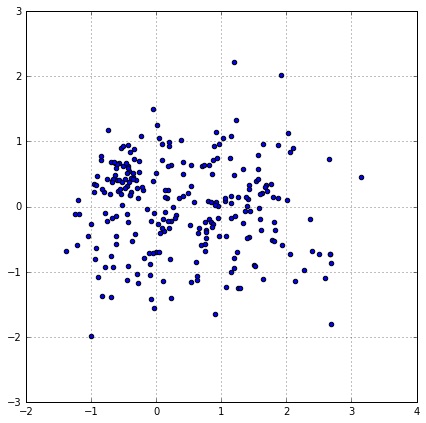

In [38]:
plt.figure(figsize=(7,7))
plt.scatter(points[:, 0], points[:, 1])
plt.grid()
plt.show()

In [39]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

And lest visualize the choosen (initial) centroids:

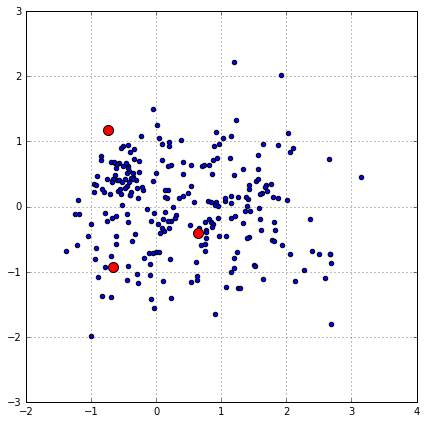

In [40]:
centroids = initialize_centroids(points, 3)

plt.figure(figsize=(7,7))
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)
plt.grid()
plt.show()

The following function computes which is the closest centroid for each point in the dataset

In [42]:
def closest_centroid(points,centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    # computation of distance matrix
    m = points.shape[0]
    n = centroids.shape[0]
    D = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            D[i,j] = np.sqrt( np.sum( (points[i]-centroids[j])**2 ) )
    return np.argmin(D, axis=1)

In [46]:
closest = closest_centroid(points,centroids)

And the next function __move/update__ the centroids according to the mean position of the cluster of points

In [47]:
def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

In [48]:
move_centroids(points, closest, centroids)

array([[ 1.12402765, -0.08113644],
       [-0.40321162,  0.60019621],
       [-0.57634669, -0.72368945]])

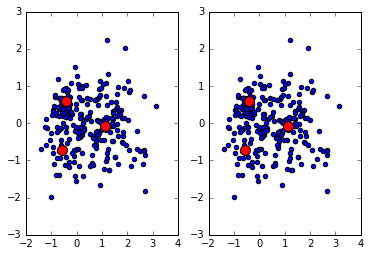

In [50]:
plt.subplot(121)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

centroids = move_centroids(points, closest, centroids)

plt.subplot(122)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)
plt.show()

In [51]:
def main_loop(points, centroids, n_iter, tol=1e-8):
    for i in range(n_iter):
        closest = closest_centroid(points, centroids)
        _centroids = move_centroids(points, closest, centroids)
        if np.sum((_centroids-centroids)**2, axis=1).max() < tol:
            centroids = _centroids
            break
        centroids = _centroids
    return centroids

Now let's profile the execution of this funcion and its sub-functions calls. We use a set of $10000$ points now:

In [52]:
points = np.vstack(((np.random.randn(5000, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(2500, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(2500, 2) * 0.5 + np.array([-0.5, -0.5]))))

In [53]:
%%prun -s cumulative -q -l 15 -T prun1
main_loop(points, centroids, 1000)

 
*** Profile printout saved to text file u'prun1'. 


In [54]:
print(open('prun1', 'r').read())

         4031306 function calls in 8.597 seconds

   Ordered by: cumulative time
   List reduced from 21 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.597    8.597 <string>:2(<module>)
        1    0.001    0.001    8.597    8.597 <ipython-input-51-27467b285d0a>:1(main_loop)
       31    4.099    0.132    8.573    0.277 <ipython-input-42-af93b75f3bb8>:1(closest_centroid)
   930031    1.529    0.000    4.326    0.000 fromnumeric.py:1743(sum)
   930031    0.332    0.000    2.439    0.000 _methods.py:31(_sum)
   930155    2.114    0.000    2.114    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   930217    0.358    0.000    0.358    0.000 {isinstance}
   310063    0.145    0.000    0.145    0.000 {range}
       31    0.013    0.000    0.022    0.001 <ipython-input-47-a8bc1b8c3b4f>:1(move_centroids)
       93    0.000    0.000    0.009    0.000 {method 'mean' of 'numpy.ndarray' objects}
       93  

Clearly the problem is the __`closest_centroid`__ function!. Now that we have isolated the problem, we do a line profile of this single function:

In [55]:
%lprun -T lprof2 -f closest_centroid closest_centroid(points, centroids)


*** Profile printout saved to text file u'lprof2'. 


In [56]:
print(open('lprof2', 'r').read())

Timer unit: 1e-06 s

Total time: 0.398152 s
File: <ipython-input-42-af93b75f3bb8>
Function: closest_centroid at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def closest_centroid(points,centroids):
     2                                               """returns an array containing the index to the nearest centroid for each point"""
     3                                               # computation of distance matrix
     4         1            5      5.0      0.0      m = points.shape[0]
     5         1            1      1.0      0.0      n = centroids.shape[0]
     6         1          226    226.0      0.1      D = np.zeros((m,n))
     7     10001         6259      0.6      1.6      for i in range(m):
     8     40000        33055      0.8      8.3          for j in range(n):
     9     30000       358449     11.9     90.0              D[i,j] = np.sqrt( np.sum( (points[i]-centroids[j])**2 ) )
    10         1 

As you should suspect, the problem is that NumPy arrays are not meant to be iterated by Python, but we have to implement this algorithm in a vectorial way (or make it faster with Numba/Cython). 

The next is a re-implementation of the algorithm, using native NumPy functions:

In [57]:
def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    px = points[:,0].reshape((-1,1))
    py = points[:,1].reshape((-1,1))
    Dx = px - centroids[:,0].reshape((1,-1))
    Dy = py - centroids[:,1].reshape((1,-1))
    # distance matrix
    D = np.sqrt(Dx**2+Dy**2)
    return np.argmin(D, axis=1)

Let's profile again:

In [58]:
%%prun -s cumulative -q -l 15 -T prun2
main_loop(points, centroids, 1000)

 
*** Profile printout saved to text file u'prun2'. 


In [59]:
print(open('prun2', 'r').read())

         1368 function calls in 0.045 seconds

   Ordered by: cumulative time
   List reduced from 21 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.045    0.045 <string>:2(<module>)
        1    0.001    0.001    0.045    0.045 <ipython-input-51-27467b285d0a>:1(main_loop)
       31    0.019    0.001    0.022    0.001 <ipython-input-57-55f62e6f8a48>:1(closest_centroid)
       31    0.012    0.000    0.022    0.001 <ipython-input-47-a8bc1b8c3b4f>:1(move_centroids)
       93    0.000    0.000    0.009    0.000 {method 'mean' of 'numpy.ndarray' objects}
       93    0.001    0.000    0.009    0.000 _methods.py:53(_mean)
      155    0.008    0.000    0.008    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       31    0.000    0.000    0.003    0.000 fromnumeric.py:976(argmin)
       31    0.003    0.000    0.003    0.000 {method 'argmin' of 'numpy.ndarray' objects}
       31    0.000    0.000    0.

__Mr Knuth will be proud :)__

## Another interesting tools for profiling

* [__RunSnakeRun__]( www.vrplumber.com/programming/runsnakerun/), a GUI tools for exploring and visualizing the output of a profiling session.
* Python's __trace__ module it is extremely useful during in-depth debugging and profiling sessions. [More info](https://docs.python.org/3/library/trace.html).
* (Memory) [Guppy-PE](http://guppy-pe.sourceforge.net/), [PySizer](http://pysizer.8325.org) and [Pympler](https://code.google.com/p/pympler/).